In [1]:
import json
import re
from collections import Counter, defaultdict
from typing import Any, Dict, List

from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             roc_auc_score)
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import eli5
import fasttext
import seaborn as sns
from natasha import (
    Segmenter,
    MorphVocab,

    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,

    PER,
    NamesExtractor,

    Doc
)

Array = Any

In [2]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)
names_extractor = NamesExtractor(morph_vocab)

In [2]:
filename = "dataset/clean_csv/text.csv"

df = pd.read_csv(filename)

In [40]:
model = fasttext.load_model("pretrained/ft_native_300_ru_twitter_nltk_word_tokenize.bin")

In [4]:
def get_average_fasttext(words):
    embeds = []
    for word in words:
        if word in model:
            embeds.append(model[word])
    return np.mean(embeds, axis=0)


In [5]:
df = df[['date', 'clipTarget', 'description']]
df_train = df.iloc[:324160, :]
df_train = df_train.dropna(subset=['description']).reset_index(drop=True)


df_test = df.iloc[324160:, :]
df_test = df_test.dropna(subset=['description']).reset_index(drop=True)
del df

In [5]:
def text_preprocessing(data):
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    stop = stopwords.words('russian')
    data  = " ".join(x.lower() for x in data.split())
    data = data.replace('[^\w\s]','')
    data = data.replace('#',' ')
    data = " ".join(x for x in data.split() if x not in stop)
    for sent in data:
        if sent in punc:
            data = data.replace(sent, "")
    return data

In [27]:
df_train['clean_text'] = df_train["description"].apply(lambda row: text_preprocessing(row))
df_test['clean_text'] = df_test["description"].apply(lambda row: text_preprocessing(row))

In [6]:
def lemmatize(text):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
    tokens = []
    for token in doc.tokens:
        tokens.append(token.lemma)
    return tokens

In [30]:
df_train['lemma'] = df_train["clean_text"].apply(lambda row: lemmatize(row))
df_test['lemma'] = df_test["clean_text"].apply(lambda row: lemmatize(row))

In [67]:
df_train.sample(5)

,date,clipTarget,description,clean_text,lemma
20512,2022-04-03,TRAVEL,#Гиза #китай #интересное #история,гиза китай интересное история,"[гиз, китай, интересный, история]"
222180,2022-07-06,TRAVEL,Лучшие места Приморья Часть . Сохраняй🔥 ⠀ Путе...,лучшие места приморья часть сохраняй🔥 ⠀ путеш...,"[хороший, место, приморье, часть, сохраняй🔥, ⠀..."
96209,2022-04-30,DANCE,Залатинились с девчонками в 👯‍♀️💃🏼 Я уже пол г...,залатинились девчонками 👯‍♀️💃🏼 пол года каждый...,"[залатинилися, девчонка, 👯‍♀️💃🏼, пол, год, каж..."
194080,2022-06-16,SPORT,#лайктайм #liketime,лайктайм liketime,"[лайктайм, liketime]"
63563,2022-04-18,BLOG,#мнениеитальянца,мнениеитальянца,[мнениеитальянец]


In [39]:
X_train_text = [get_average_fasttext(text) for text in df_train['lemma'].to_list()]
X_test_text = [get_average_fasttext(text) for text in df_test['lemma'].to_list()]

/home/xrenya/miniconda3/envs/dev/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/xrenya/miniconda3/envs/dev/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [51]:
train = [mat if len(mat.shape) > 0 else np.zeros(100) for mat in X_train_text]

In [54]:
test = [mat if len(mat.shape) > 0 else np.zeros(100) for mat in X_test_text]

In [57]:
log_reg = LogisticRegression(solver='newton-cg')

In [61]:
model = log_reg.fit(train, df_train["clipTarget"])

In [62]:
print(roc_auc_score(df_test["clipTarget"].to_list(), model.predict_proba(test), multi_class='ovr'))
print(f1_score(df_test["clipTarget"].to_list(), model.predict(test), average='macro'))

0.8238701277820059
0.2514850436668297


In [64]:
np.array(train).shape

(225242, 100)

In [65]:
# np.save('dataset/description/train_desc.npy', np.array(train))
# np.save('dataset/description/test_desc.npy', np.array(test))
# df_train.to_csv("dataset/clean_csv/lemma_train.csv", index=False)
# df_test.to_csv("dataset/clean_csv/lemma_test.csv", index=False)

In [34]:
del df_train, df_test, train, test

In [35]:
filename = "dataset/clean_csv/text.csv"

df = pd.read_csv(filename)

In [36]:
df = df[['date', 'clipTarget', 'asr']]
df_train = df.iloc[:324160, :]
df_train = df_train.dropna(subset=['asr']).reset_index(drop=True)


df_test = df.iloc[324160:, :]
df_test = df_test.dropna(subset=['asr']).reset_index(drop=True)
del df

In [37]:
df_train['clean_asr'] = df_train["asr"].apply(lambda row: text_preprocessing(row))
df_test['clean_asr'] = df_test["asr"].apply(lambda row: text_preprocessing(row))

In [38]:
df_train['lemma_asr'] = df_train["clean_asr"].apply(lambda row: lemmatize(row))
df_test['lemma_asr'] = df_test["clean_asr"].apply(lambda row: lemmatize(row))

In [12]:
df_train.sample(5)

,date,clipTarget,asr,clean_asr,lemma_asr
2868,2022-04-06,THEATER,Так вот эти персонажи у нас выглядели на изах ...,персонажи выглядели изах это отит это соответс...,"[персонаж, выглядеть, изах, это, отит, это, со..."
6375,2022-04-07,FOOD,Приготовим быстрый и простой вариант ужина блю...,приготовим быстрый простой вариант ужина блюдо...,"[приготовить, быстрый, простой, вариант, ужин,..."
2335,2022-04-06,BLOG,Сегодня день весеннего равноденствия и иди на ...,сегодня день весеннего равноденствия иди это в...,"[сегодня, день, весенний, равноденствие, идти,..."
935,2022-04-05,KIDS,"И он не прочел, который день они заметил, а св...",прочел который день заметил своим духом навстр...,"[прочесть, который, день, заметить, свой, дух,..."
904,2022-04-05,KIDS,"Не сиди солнце и коте говорили, все тут ничего...",сиди солнце коте говорили светит раскрасим пит...,"[сиди, солнце, кот, говорить, светит, раскраси..."


In [13]:
# df_train.to_csv("dataset/clean_csv/lemma_train_asr.csv", index=False)
# df_test.to_csv("dataset/clean_csv/lemma_test_asr.csv", index=False)

In [41]:
X_train_text = [get_average_fasttext(text) for text in df_train['lemma_asr'].to_list()]
X_test_text = [get_average_fasttext(text) for text in df_test['lemma_asr'].to_list()]

/home/xrenya/miniconda3/envs/dev/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/xrenya/miniconda3/envs/dev/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [42]:
train = np.array([mat if len(mat.shape) > 0 else np.zeros(100) for mat in X_train_text])
test = np.array([mat if len(mat.shape) > 0 else np.zeros(100) for mat in X_test_text])

In [43]:
# np.save('dataset/description/train_asr.npy', train)
# np.save('dataset/description/test_asr.npy', test)

In [18]:
log_reg = LogisticRegression(solver='newton-cg')

In [19]:
model = log_reg.fit(train, df_train["clipTarget"])

In [21]:
# print(roc_auc_score(df_test["clipTarget"].to_list(), model.predict_proba(test), multi_class='ovr'))
print(f1_score(df_test["clipTarget"].to_list(), model.predict(test), average='macro'))

0.11045315174567663


In [7]:
filename = "dataset/clean_csv/text.csv"

df = pd.read_csv(filename)

In [9]:
df = pd.read_csv(filename)
df_train = df.iloc[:324160, :]
df_train = df_train.reset_index(drop=True)


df_test = df.iloc[324160:, :]
df_test = df_test.reset_index(drop=True)
del df

In [10]:
df_train["asr"] = df_train["asr"].apply(lambda row: row if isinstance(row, str) else "")
df_train["description"] = df_train["description"].apply(lambda row: row if isinstance(row, str) else "")
df_train["text"] = df_train["asr"] + df_train["description"]

In [11]:
columns = ["clipTarget", "text"]

In [12]:
df_train = df_train[df_train["text"] != ""].reset_index(drop=True)
df_train = df_train[columns].reset_index(drop=True)
df_train

,clipTarget,text
0,ANIMALS,🐶🐕🐩🐾 #ЦвергПинчер #МиниДоберман #ФедяПинчер #F...
1,DANCE,🤩Подруга-ночь🌃-мне не до сна 🙅‍♀️💃👏 #подругано...
2,FOOD,"Всем, привет Я обожаю делать приятные сюрпризы..."
3,ANIMALS,Коротко о нашем коте Лемуре😁#farm #farmer #far...
4,FITNESS,"Если не можешь, значит, можешь🤍 #ironcros#gym#..."
...,...,...
229077,CULTURE,#высотанавека #высота #верёвки #жумар #жумарь ...
229078,KIDS,Радость в мелочах 🍁 #счастьеесть #счастье #доч...
229079,SPORT,Танец сегодня – это способ самовыражения. Кто-...
229080,BEAUTY,"🙀У нас был всего час времени 🧚🏻‍♀️ , ты просто..."


In [13]:
df_train['clean_text'] = df_train["text"].apply(lambda row: text_preprocessing(row))
df_train

,clipTarget,text,clean_text
0,ANIMALS,🐶🐕🐩🐾 #ЦвергПинчер #МиниДоберман #ФедяПинчер #F...,🐶🐕🐩🐾 цвергпинчер минидоберман федяпинчер fedya...
1,DANCE,🤩Подруга-ночь🌃-мне не до сна 🙅‍♀️💃👏 #подругано...,🤩подруганочь🌃мне сна 🙅‍♀️💃👏 подруганочь девушк...
2,FOOD,"Всем, привет Я обожаю делать приятные сюрпризы...",всем привет обожаю делать приятные сюрпризы лю...
3,ANIMALS,Коротко о нашем коте Лемуре😁#farm #farmer #far...,коротко нашем коте лемуре😁 farm farmer farmani...
4,FITNESS,"Если не можешь, значит, можешь🤍 #ironcros#gym#...",можешь значит можешь🤍 ironcros gym fitnes top ...
...,...,...,...
229077,CULTURE,#высотанавека #высота #верёвки #жумар #жумарь ...,высотанавека высота верёвки жумар жумарь сезон...
229078,KIDS,Радость в мелочах 🍁 #счастьеесть #счастье #доч...,радость мелочах 🍁 счастьеесть счастье доченька...
229079,SPORT,Танец сегодня – это способ самовыражения. Кто-...,танец сегодня – это способ самовыражения ктото...
229080,BEAUTY,"🙀У нас был всего час времени 🧚🏻‍♀️ , ты просто...",🙀у час времени 🧚🏻‍♀️ просто феяволшебница ❤️ ...


In [14]:
df_test["asr"] = df_test["asr"].apply(lambda row: row if isinstance(row, str) else "")
df_test["description"] = df_test["description"].apply(lambda row: row if isinstance(row, str) else "")
df_test["text"] = df_test["asr"] + df_test["description"]

In [15]:
df_test = df_test[df_test["text"] != ""].reset_index(drop=True)
df_test = df_test[columns].reset_index(drop=True)
df_test

,clipTarget,text
0,DANCE,#ЯТвойКосмос #Гагарин
1,FAMILY,Первый раз на море 😍счастье наше❤️😘
2,FITNESS,Открытые занятия в усадьбе Кривякино каждое во...
3,ANIMALS,После умственного тренинга можно и на тарзанке...
4,FAMILY,"июня года в . , в очень жаркий петербургский д..."
...,...,...
38530,HUMOR,"Вчера снимали новый выпуск Шоперов, в пятницу ..."
38531,FITNESS,Если было полезно ставь ❤️ #тренировкидома #зд...
38532,FITNESS,Лицом по касательной к стене прошел😂✈️
38533,KIDS,❤️😋


In [17]:
df_test['clean_text'] = df_test["text"].apply(lambda row: text_preprocessing(row))
df_test

,clipTarget,text,clean_text
0,DANCE,#ЯТвойКосмос #Гагарин,ятвойкосмос гагарин
1,FAMILY,Первый раз на море 😍счастье наше❤️😘,первый море 😍счастье наше❤️😘
2,FITNESS,Открытые занятия в усадьбе Кривякино каждое во...,открытые занятия усадьбе кривякино каждое воск...
3,ANIMALS,После умственного тренинга можно и на тарзанке...,умственного тренинга тарзанке поработать 😈 аку...
4,FAMILY,"июня года в . , в очень жаркий петербургский д...",июня года очень жаркий петербургский день св...
...,...,...,...
38530,HUMOR,"Вчера снимали новый выпуск Шоперов, в пятницу ...",вчера снимали новый выпуск шоперов пятницу сно...
38531,FITNESS,Если было полезно ставь ❤️ #тренировкидома #зд...,полезно ставь ❤️ тренировкидома здороваяспина ...
38532,FITNESS,Лицом по касательной к стене прошел😂✈️,лицом касательной стене прошел😂✈️
38533,KIDS,❤️😋,❤️😋


In [18]:
df_train['lemma_asr_desc'] = df_train["clean_text"].apply(lambda row: lemmatize(row))
df_test['lemma_asr_desc'] = df_test["clean_text"].apply(lambda row: lemmatize(row))

In [20]:
df_train.sample(5)

,clipTarget,text,clean_text,lemma_asr_desc
74558,FITNESS,I LIKE IT 😏👌,i like it 😏👌,"[i, like, it, 😏👌]"
94763,MOVIES,Идрис Альба,идрис альба,"[идрис, альба]"
25765,SPORT,#insta #загороднаяжизнь #северныемальдивы #поп...,insta загороднаяжизнь северныемальдивы попробу...,"[insta, загороднаяжизнь, северныемальдивы, поп..."
185487,BEAUTY,Пухлые губы за минут😍,пухлые губы минут😍,"[пухлый, губа, минут😍]"
135983,HUMOR,А что останавливало/ останавливает вас от онла...,останавливало останавливает онлайна онлайнпеда...,"[останавливать, останавливать, онлайн, онлайнп..."


In [33]:
# df_train.to_csv("dataset/clean_csv/lemma_train_asr_desc.csv", index=False)
# df_test.to_csv("dataset/clean_csv/lemma_test_asr_desc.csv", index=False)

In [21]:
X_train_text = [get_average_fasttext(text) for text in df_train['lemma_asr_desc'].to_list()]
X_test_text = [get_average_fasttext(text) for text in df_test['lemma_asr_desc'].to_list()]

/home/xrenya/miniconda3/envs/dev/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/xrenya/miniconda3/envs/dev/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [24]:
train = np.array([mat if len(mat.shape) > 0 else np.zeros(100) for mat in X_train_text])
test = np.array([mat if len(mat.shape) > 0 else np.zeros(100) for mat in X_test_text])

In [29]:
# np.save('dataset/description/train_asr_desc.npy', train)
# np.save('dataset/description/test_asr_desc.npy', test)

In [30]:
log_reg = LogisticRegression(solver='newton-cg')

In [31]:
model = log_reg.fit(train, df_train["clipTarget"])

In [32]:
print(roc_auc_score(df_test["clipTarget"].to_list(), model.predict_proba(test), multi_class='ovr'))
print(f1_score(df_test["clipTarget"].to_list(), model.predict(test), average='macro'))

0.823631260029767
0.25200908692824897


In [2]:
df = pd.read_csv("results/f1_scores.csv")

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'BoW/LR'),
  Text(1, 0, 'Catboost'),
  Text(2, 0, 'MLP'),
  Text(3, 0, 'CNN1D'),
  Text(4, 0, 'Attention'),
  Text(5, 0, 'Tf-Idf/LR'),
  Text(6, 0, 'fasttext (average)'),
  Text(7, 0, 'Catboost/fasttext')])

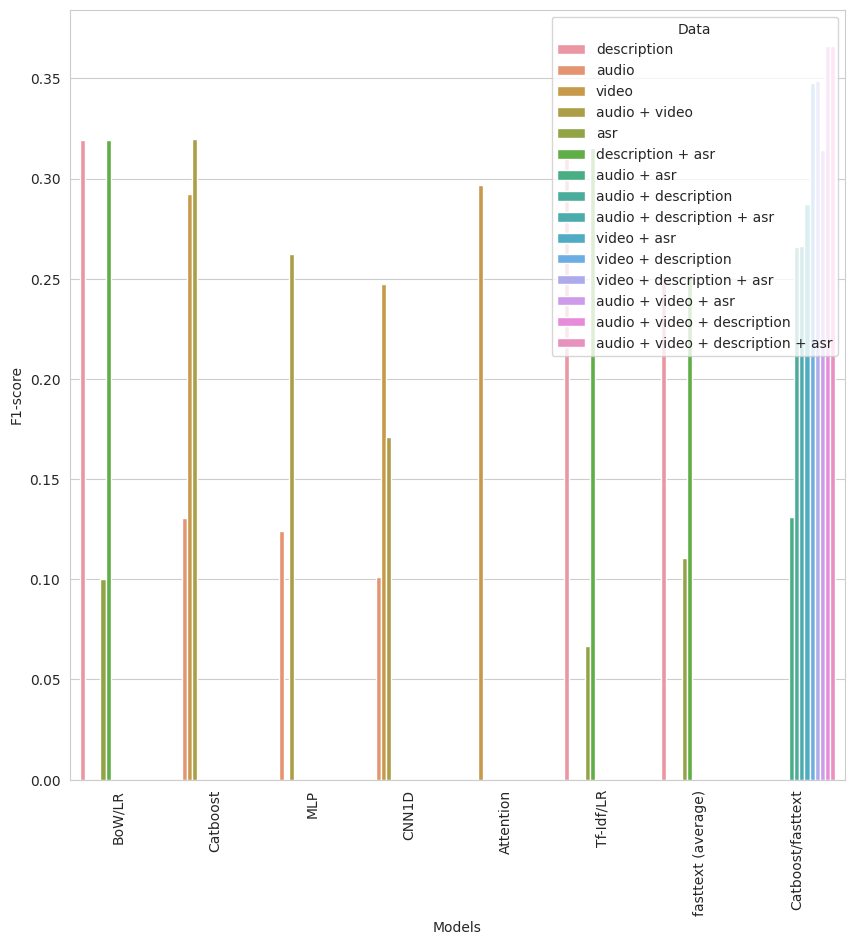

In [8]:
plt.figure(figsize=(10, 10))
sns.barplot(data=df, x="Models", y="F1-score", hue="Data")
plt.xticks(rotation=90)